# Coupling Analysis

---

### 0.1 Prerequisite

- When changing the python class in the lib directory please restart kernel.
- When launching the jupyter notebook please always firstly run this cell.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import constants
import scipy.sparse.linalg
import scipy.sparse as sparse
import qutip.settings as settings
from tqdm import tqdm
import qutip as qt

qt.settings.atol = 1e-100
qt.settings.auto_tidyup_atol = qt.settings.atol

current_dir = os.getcwd()

# Get the parent folder path
parent_dir = os.path.dirname(current_dir)

# Add the parent folder path to sys.path
sys.path.append(parent_dir)

from lib.qubit import qubit
from lib.circuit_res_trans import circuit_res_trans



# plt.style.use('dark_background')
thememap = 'viridis'

# Setting up constants
h = constants.h
hbar = constants.hbar
pi = np.pi

---

The system is composed of a Transmon qubit coupled to a capacitor. The nodes are defined as the graph below : 

(ADD GRAPH)

#### Table of content :
   1) Visualization of the Hamiltonian
   2) Getting the interaction Matrix
   3) Varying the coupling parameter with system variable

### 1. Visualization of the Hamiltonian


In [2]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 1.2e-15
Ej_p = 9e9
Cp = 150e-15
ncut_p = 10
Cr = 100e-15
Lr = 10e-9
mcut_r = 10

# Creation of circuit object
system_1 = circuit_res_trans(Cc, Cr, Lr, mcut_r, qubit(Ej_p, [Cp], ng, ncut_p))

system_1.print_params()

Ej:    9.000000000000002 GHz
Ec:    0.5165394486575766 GHz
Cj:    150.0 fF
Ej/Ec : 17.423645035030546
w_01:    5.514819687337774 GHz
ng:    0.5
Cc:    1.2 fF
Cr:    100.0 fF
Lr:    10.0 nH
Z0:    316.22776601683796 Ohm
wr:    5.032921210448705 Ghz


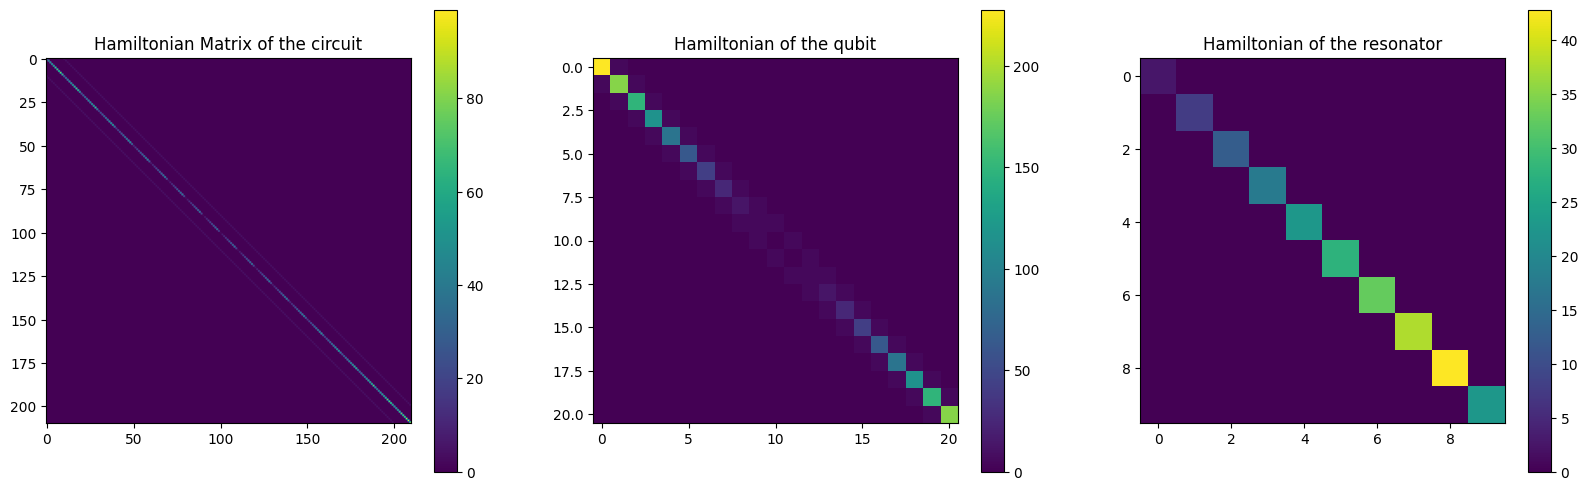

In [3]:
# Exctracting the Hamiltonian
H_circ = system_1.get_H_circuit()
H_q = system_1.get_H_qubit()
H_r = system_1.get_H_res()

f = plt.figure(figsize=(20,6))

# Plotting the Hamiltonian
ax1 = f.add_subplot(131)
ax1.title.set_text('Hamiltonian Matrix of the circuit')
im1 = ax1.imshow(np.absolute(H_circ.full() / constants.h * 1e-9), cmap=plt.get_cmap(thememap))
f.colorbar(im1)

ax2 = f.add_subplot(132)
ax2.title.set_text('Hamiltonian of the qubit')
im2 = ax2.imshow(np.abs(H_q.full()/ constants.h * 1e-9), cmap=plt.get_cmap(thememap))
f.colorbar(im2)


ax3 = f.add_subplot(133)
ax3.title.set_text('Hamiltonian of the resonator')
im3 = ax3.imshow(np.abs(H_r.full()/ constants.h * 1e-9), cmap=plt.get_cmap(thememap))
f.colorbar(im3)

ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

plt.show()

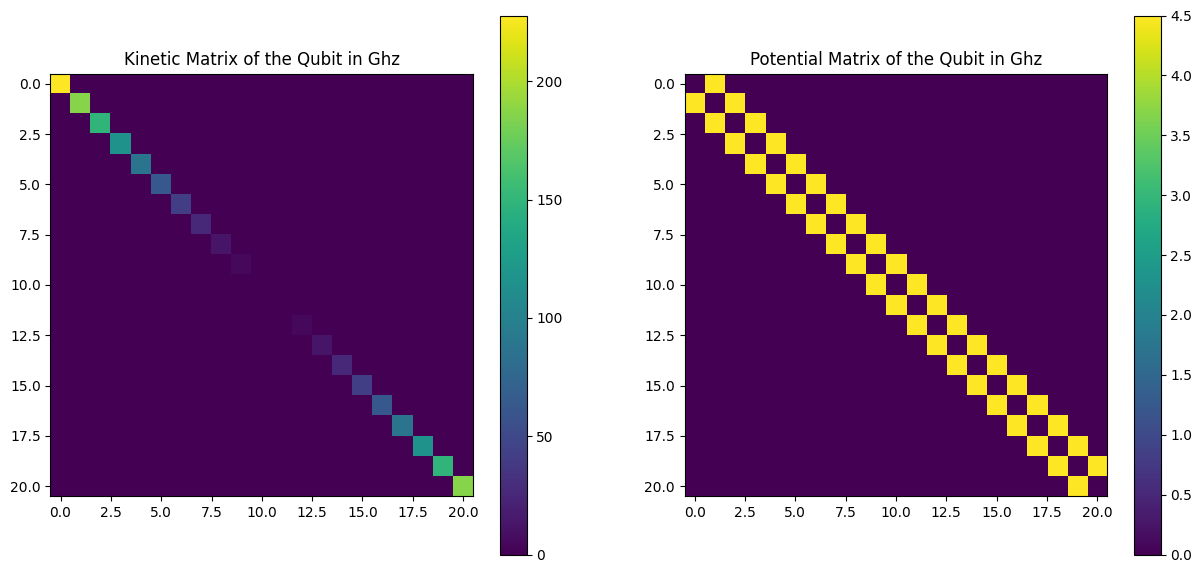

In [4]:
kin_probe = system_1.get_kinetic_qubit()
pot_probe = system_1.get_potential_qubit()

if type(kin_probe) == scipy.sparse.csr_matrix:
    kin_probe = kin_probe.toarray()
    pot_probe = pot_probe.toarray()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Kinetic Matrix of the Qubit in Ghz')
im1 = ax1.imshow(np.abs(kin_probe.full())/ constants.h * 1e-9, cmap=plt.get_cmap(thememap))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Potential Matrix of the Qubit in Ghz')
im2 = ax2.imshow(np.abs(pot_probe.full())/ constants.h * 1e-9, cmap=plt.get_cmap(thememap))
f.colorbar(im2)

ax1.grid(False)
ax2.grid(False)

plt.show()

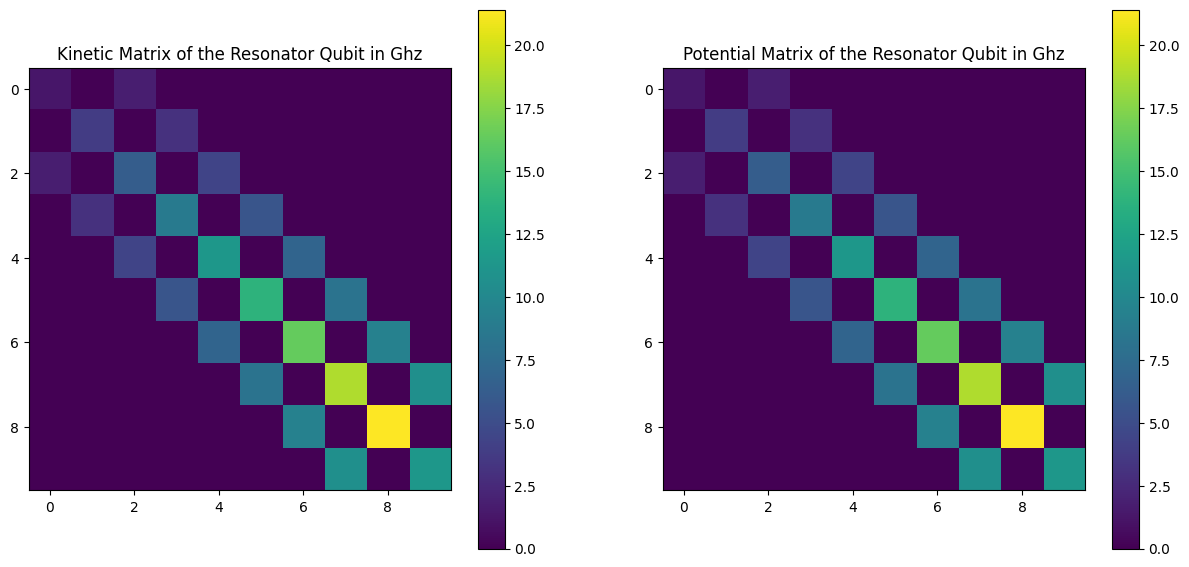

In [5]:
kin_target = system_1.get_kinetic_res()
pot_target = system_1.get_potential_res()


f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Kinetic Matrix of the Resonator Qubit in Ghz')
im1 = ax1.imshow(np.absolute(kin_target.full())/ constants.h * 1e-9, cmap=plt.get_cmap(thememap))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Potential Matrix of the Resonator Qubit in Ghz')
im2 = ax2.imshow(np.absolute(pot_target.full())/ constants.h * 1e-9, cmap=plt.get_cmap(thememap))
f.colorbar(im2)
ax1.grid(False)
ax2.grid(False)
plt.show()


### 2. Qubit cavity coupling terms

We assume that the Hamiltonian can be approximated by

\begin{equation}
    H = \omega_r' a^\dagger a + \frac{\Delta}{2} \sigma_z + i g_{\parallel} \sigma_z \left( a^\dagger - a \right) + g_{\perp} \sigma_x \left( a^\dagger + a \right)
\end{equation}

which when writing the two subspaces explicitly is written as

\begin{equation}
    H = \omega_r' \mathbb{1} \otimes a^\dagger a + \frac{\Delta}{2} \sigma_z \otimes \mathbb{1} + i g_{\parallel} \sigma_z \otimes \left( a^\dagger - a \right) + g_{\perp} \sigma_x \otimes \left( a^\dagger + a \right)
\end{equation}

To find the parameters we can evaluate the following overlaps:

\begin{equation}
    \langle 0 | \langle 0 | H | 0 \rangle | 0 \rangle = \frac{\Delta}{2}
\end{equation}

\begin{equation}
    \langle 0 | \langle 1 | H | 0 \rangle | 1 \rangle = \omega_r' + \frac{\Delta}{2}
\end{equation}

\begin{equation}
    \langle + | \langle 1 | H | - \rangle | 0 \rangle = i g_{\parallel}
\end{equation}

\begin{equation}
    \langle 1 | \langle 1 | H | 0 \rangle | 0 \rangle = g_{\perp}
\end{equation}

where we use the notation $| \text{Qubit} \rangle | \text{Cavity} \rangle$

Parameter check

In [6]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 1.2e-15
Ej_p = 9e9
Cp = 150e-15
ncut_p = 10
Cr = 100e-15
Lr = 10e-9
mcut_r = 10

# Creation of circuit object
system_2 = circuit_res_trans(Cc, Cr, Lr, mcut_r, qubit(Ej_p, [Cp], ng, ncut_p))

system_2.print_params()

g_parr = system_2.get_gparr()
print(f"g parallel: {g_parr}")

g_perp = system_2.get_gperp()
print(f"g perpendicular: {g_perp}")

delta = system_2.get_delta_qubit()
print(f"delta: {delta / constants.h * 1e-9}")

omega = system_2.get_omega_res()
print(f"omega: {omega /constants.h * 1e-9}")

Ej:    9.000000000000002 GHz
Ec:    0.5165394486575766 GHz
Cj:    150.0 fF
Ej/Ec : 17.423645035030546
w_01:    5.514819687337774 GHz
ng:    0.5
Cc:    1.2 fF
Cr:    100.0 fF
Lr:    10.0 nH
Z0:    316.22776601683796 Ohm
wr:    5.032921210448705 Ghz
g parallel: -1.2515129842198338e-43j
g perpendicular: 8.382272873713222e-27j
delta: (-8.229426144934816+0j)
omega: (5.003315791563713+0j)


#### Varying Cc

Ej:    18.200000000000003 GHz
Ec:    0.2869663603653203 GHz
Cj:    270.0 fF
Ej/Ec : 63.42206792751119
w_01:    6.167224042050487 GHz
ng:    0.5
Cc:    18.0 fF
Cr:    10.0 fF
Lr:    3.5 nH
Z0:    591.6079783099616 Ohm
wr:    26.90209546303806 Ghz


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:29<00:00, 33.93it/s]


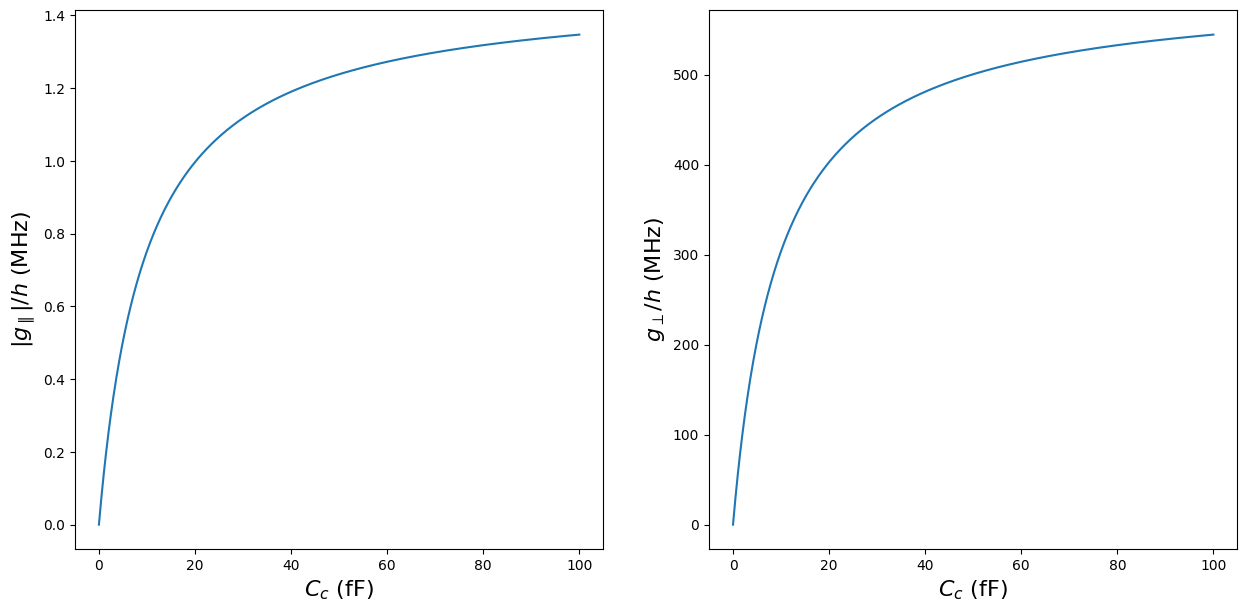

In [14]:
# Initialize transmon

# Circuit constant
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 5
ncut_t = 10

Lr = 3.5e-9
Cr = 10e-15
mcut_r = 5

# Creation of circuit object
system_3 = circuit_res_trans(Cc, Cr, Lr, mcut_r, qubit(Ej_p, [Cp], ng, ncut_p))

system_3.print_params()

Ccs = np.linspace(0, 10e-14, 1000)

fig_data_gparr = []
fig_data_gperp = []

for Cc in tqdm(Ccs):
    system_3.Cc = Cc

    # Full Hamiltonina Approach
    g_parr = system_3.get_gparr(update=True)
    g_perp = system_3.get_gperp()
    fig_data_gparr.append(g_parr)
    fig_data_gperp.append(g_perp)

pparam = dict(xlabel='$C_c$ (fF)', ylabel='$| g_\parallel | / h$ (MHz)')

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in Ccs], [np.abs(g_parr) * 1e-6 / constants.h for g_parr in fig_data_gparr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)
    pparam = dict(xlabel='$C_c$ (fF)', ylabel='$g_\\perp / h$ (MHz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in Ccs], [np.abs(g_parr) * 1e-6 / constants.h for g_parr in fig_data_gperp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)

    plt.show()

Ej:    18.200000000000003 GHz
Ec:    0.2869663603653203 GHz
Cj:    270.0 fF
Ej/Ec : 63.42206792751119
w_01:    6.167224042050487 GHz
ng:    0.5
Cc:    18.0 fF
Cr:    10.0 fF
Lr:    3.5 nH
Z0:    591.6079783099616 Ohm
wr:    26.90209546303806 Ghz


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 17.00it/s]


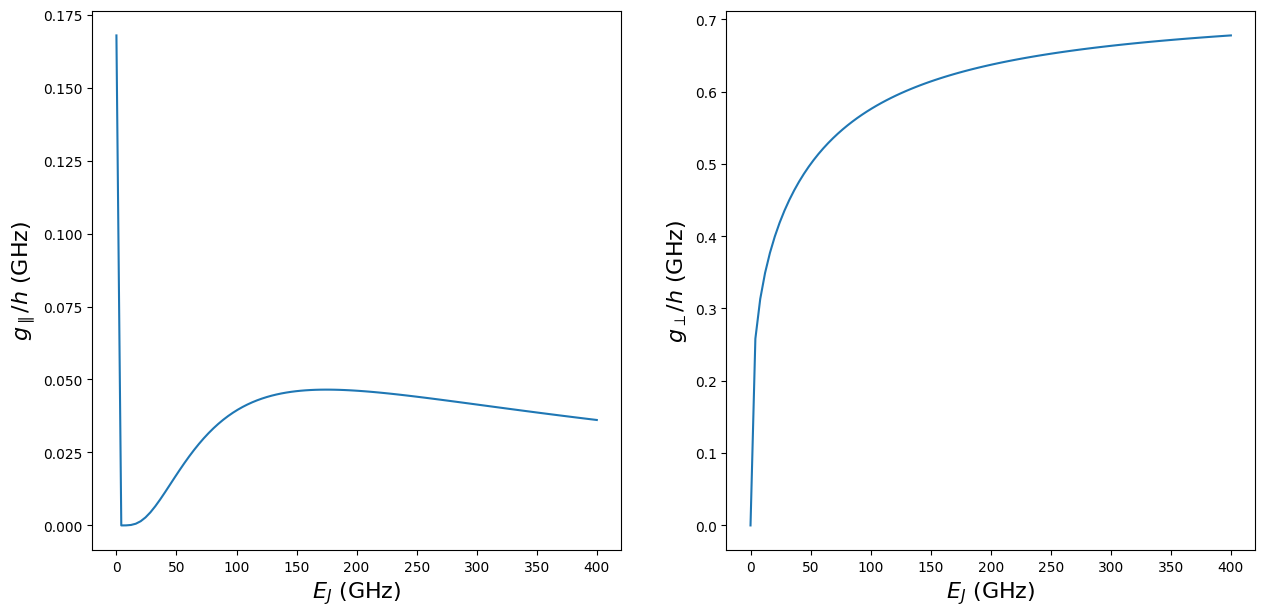

In [15]:
# Initialize transmon

# Circuit constant
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 5
ncut_t = 10

Lr = 3.5e-9
Cr = 10e-15
mcut_r = 5
# Creation of circuit object
system_4 = circuit_res_trans(Cc, Cr, Lr, mcut_r, qubit(Ej_p, [Cp], ng, ncut_p))

system_4.print_params()

Ejps = np.linspace(0, 400e9, 100)
fig_data_Ej_g_parr = []

fig_data_Ej_g_perp = []

for Ejp in tqdm(Ejps):
    system_4.qubit.Ej = Ejp * h
    
    g_parr = system_4.get_gparr(update=True)
    fig_data_Ej_g_parr.append(g_parr)
    g_perp= system_4.get_gperp(update=True)
    fig_data_Ej_g_perp.append(g_perp)
    


with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    pparam = dict(xlabel='$E_{J}$ (GHz)', ylabel='$g_\\parallel / h$ (GHz)')
    ax1.plot([val * 1e-9 for val in Ejps], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_data_Ej_g_parr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)
    pparam = dict(xlabel='$E_{J}$ (GHz)', ylabel='$g_{\perp} / h$ (GHz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e-9 for val in Ejps], [np.abs(g_perp) * 1e-9 / h for g_perp in fig_data_Ej_g_perp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)

    plt.show()

#### Varying Cp

Ej:    18.200000000000003 GHz
Ec:    0.2869663603653203 GHz
Cj:    270.0 fF
Ej/Ec : 63.42206792751119
w_01:    6.167224042050487 GHz
ng:    0.5
Cc:    18.0 fF
Cr:    10.0 fF
Lr:    3.5 nH
Z0:    591.6079783099616 Ohm
wr:    26.90209546303806 Ghz


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 33.72it/s]


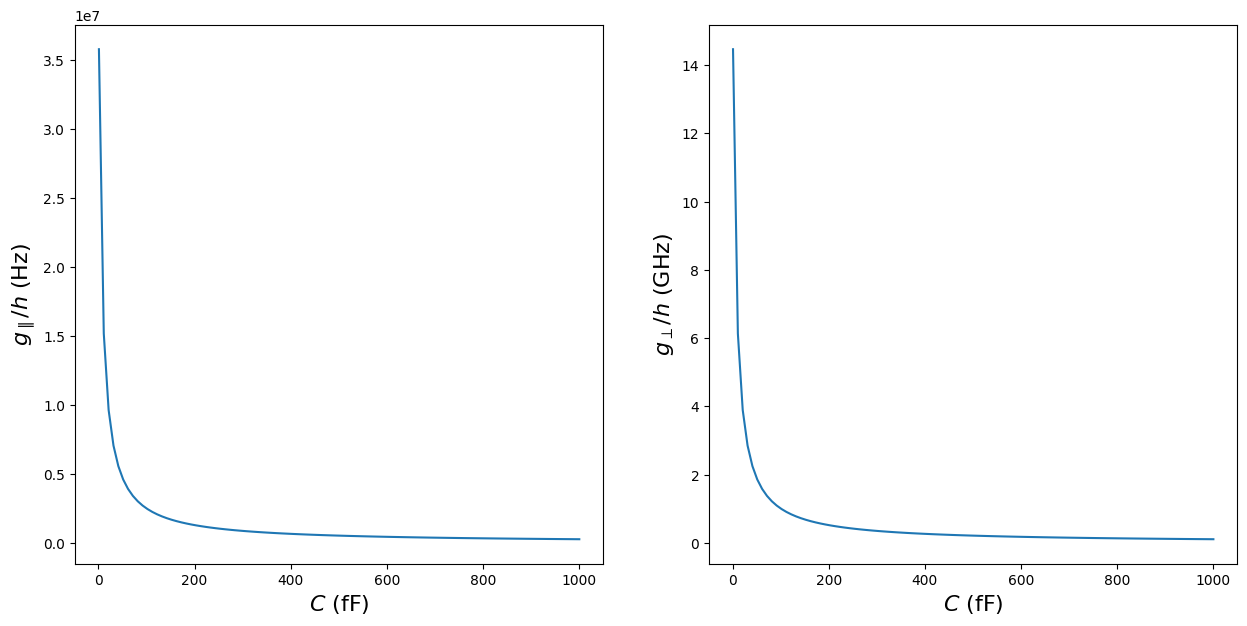

In [16]:
# Initialize transmon

# Circuit constant
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 5
ncut_t = 10

Lr = 3.5e-9
Cr = 10e-15
mcut_r = 5

# Creation of circuit object
system_5 = circuit_res_trans(Cc, Cr, Lr, mcut_r, qubit(Ej_p, [Cp], ng, ncut_p))

system_5.print_params()

Cps = np.linspace(1e-15, 10e-13, 100)
fig_pt_detuning_C_g_parr = []
fig_pt_detuning_C_g_perp = []
fig_pt_detuning_Ct = np.linspace(1e-15, 10e-13, 100)
fig_pt_detuning_Ct_g_parr = []
fig_pt_detuning_Ct_g_perp = []

for Cp in tqdm(Cps):
    system_5.qubit.C = Cp

    g_parr = system_5.get_gparr(update=True)
    fig_pt_detuning_C_g_parr.append(g_parr)
    
    g_perp = system_5.get_gperp()
    fig_pt_detuning_C_g_perp.append(g_perp)

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    pparam = dict(xlabel='$C$ (fF)', ylabel='$g_\\parallel / h$ (Hz)')
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in Cps], [np.abs(g_parr) / h for g_parr in fig_pt_detuning_C_g_parr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)

    pparam = dict(xlabel='$C$ (fF)', ylabel='$g_\\perp / h$ (GHz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in Cps], [np.abs(g_perp) * 1e-9/ h for g_perp in fig_pt_detuning_C_g_perp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)
    plt.show()


#### Varying Cr

Ej:    18.200000000000003 GHz
Ec:    0.2869663603653203 GHz
Cj:    270.0 fF
Ej/Ec : 63.42206792751119
w_01:    6.167224042050487 GHz
ng:    0.5
Cc:    18.0 fF
Cr:    10.0 fF
Lr:    3.5 nH
Z0:    591.6079783099616 Ohm
wr:    26.90209546303806 Ghz


100%|██████████| 100/100 [00:02<00:00, 33.86it/s]


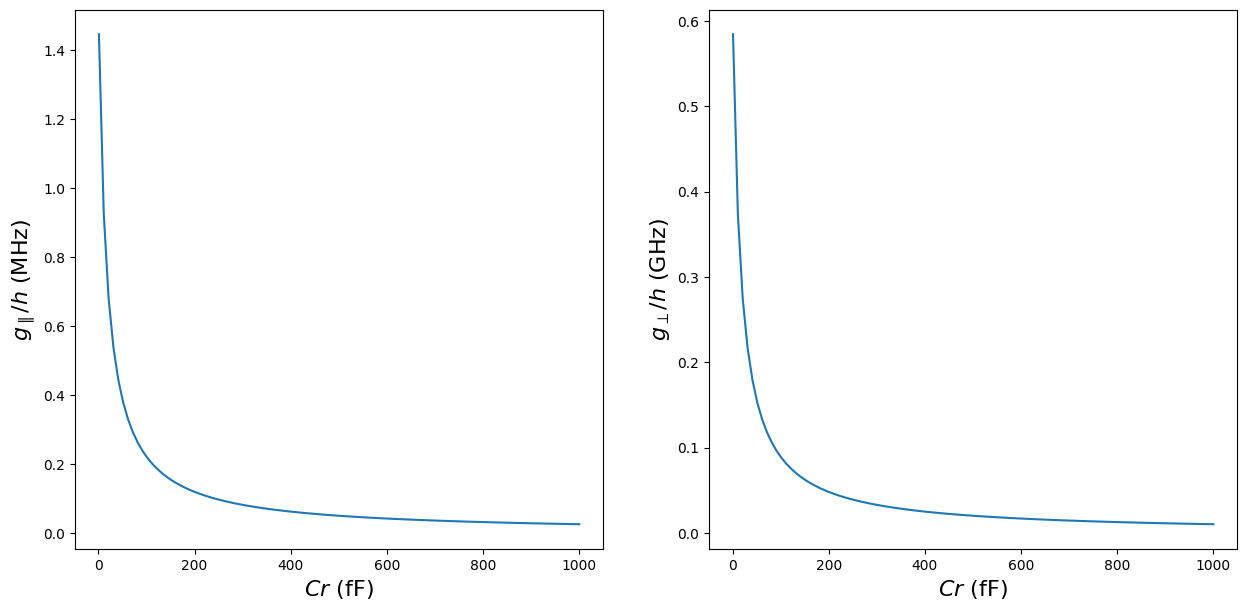

In [19]:
# Initialize transmon

# Circuit constant
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 5
ncut_t = 10

Lr = 3.5e-9
Cr = 10e-15
mcut_r = 5
# Creation of circuit object
system_6 = circuit_res_trans(Cc, Cr, Lr, mcut_r, qubit(Ej_p, [Cp], ng, ncut_p))

system_6.print_params()

Cps = np.linspace(1e-15, 10e-13, 100)
fig_pt_detuning_C_g_parr = []
fig_pt_detuning_C_g_perp = []
fig_pt_detuning_Ct = np.linspace(1e-15, 10e-13, 100)
fig_pt_detuning_Ct_g_parr = []
fig_pt_detuning_Ct_g_perp = []

for Cp in tqdm(Cps):
    system_6.res_Cr = Cp

    g_parr = system_6.get_gparr(update=True)
    fig_pt_detuning_C_g_parr.append(g_parr)
    
    g_perp = system_6.get_gperp()
    fig_pt_detuning_C_g_perp.append(g_perp)

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    pparam = dict(xlabel='$Cr$ (fF)', ylabel='$g_\\parallel / h$ (MHz)')
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in Cps], [np.abs(g_parr) * 1e-6 / h for g_parr in fig_pt_detuning_C_g_parr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)

    pparam = dict(xlabel='$Cr$ (fF)', ylabel='$g_\\perp / h$ (GHz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in Cps], [np.abs(g_perp) * 1e-9 / h for g_perp in fig_pt_detuning_C_g_perp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)
    plt.show()

#### Varying Lr

Ej:    18.200000000000003 GHz
Ec:    0.2869663603653203 GHz
Cj:    270.0 fF
Ej/Ec : 63.42206792751119
w_01:    6.167224042050487 GHz
ng:    0.5
Cc:    18.0 fF
Cr:    10.0 fF
Lr:    3.5 nH
Z0:    591.6079783099616 Ohm
wr:    26.90209546303806 Ghz


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 34.30it/s]


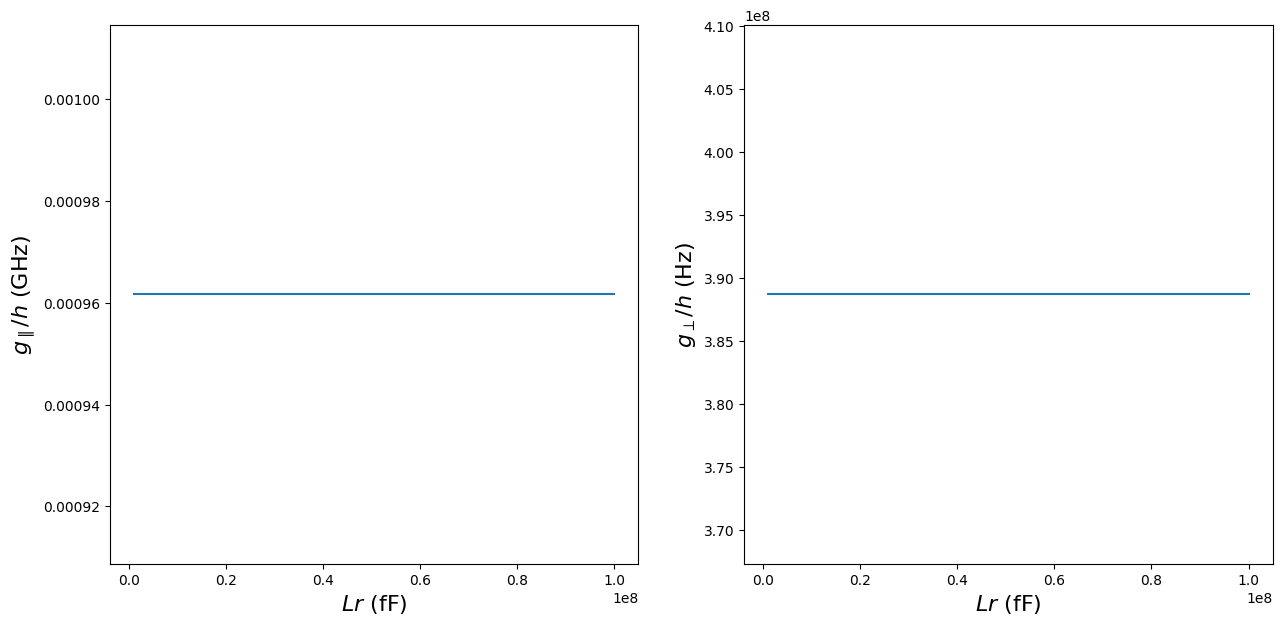

In [18]:
# Initialize transmon

# Circuit constant
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 5
ncut_t = 10

Lr = 3.5e-9
Cr = 10e-15
mcut_r = 5

# Creation of circuit object
system_6 = circuit_res_trans(Cc, Cr, Lr, mcut_r, qubit(Ej_p, [Cp], ng, ncut_p))

system_6.print_params()

Cps = np.linspace(1e-9, 100e-9, 100)
fig_pt_detuning_C_g_parr = []
fig_pt_detuning_C_g_perp = []
fig_pt_detuning_Ct = np.linspace(1e-15, 10e-13, 100)
fig_pt_detuning_Ct_g_parr = []
fig_pt_detuning_Ct_g_perp = []

for Cp in tqdm(Cps):
    system_6.res_Lr = Cp

    g_parr = system_6.get_gparr(update=True)
    fig_pt_detuning_C_g_parr.append(g_parr)
    
    g_perp = system_6.get_gperp()
    fig_pt_detuning_C_g_perp.append(g_perp)

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    pparam = dict(xlabel='$Lr$ (fF)', ylabel='$g_\\parallel / h$ (GHz)')
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in Cps], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_C_g_parr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)

    pparam = dict(xlabel='$Lr$ (fF)', ylabel='$g_\\perp / h$ (Hz)')
    ax2 = fig.add_subplot(122)
    ax2.plot([val * 1e15 for val in Cps], [np.abs(g_perp) / h for g_perp in fig_pt_detuning_C_g_perp])
    ax2.set(**pparam)
    ax2.xaxis.label.set_size(16)
    ax2.yaxis.label.set_size(16)
    plt.show()

### 3. Transmon cavity coupling terms

Ej:    18.200000000000003 GHz
Ec:    0.2869663603653203 GHz
Cj:    270.0 fF
Ej/Ec : 63.42206792751119
w_01:    6.162432921919607 GHz
ng:    0.5
Cc:    18.0 fF
Cr:    10.0 fF
Lr:    3.5 nH
Z0:    591.6079783099616 Ohm
wr:    26.90209546303806 Ghz
g : [[0.+2.22473356e-25j 0.+2.57692733e-25j 0.+2.73889520e-38j
  0.-8.13338426e-27j 0.+6.37341089e-37j 0.+5.65772568e-28j
  0.-1.40707651e-36j 0.-9.15864128e-29j 0.+8.99333737e-35j
  0.-2.42017903e-29j]
 [0.+2.57692733e-25j 0.+2.22473356e-25j 0.+3.54616415e-25j
  0.-1.02357697e-37j 0.+1.75719198e-26j 0.+7.35458576e-36j
  0.-1.68065043e-27j 0.-3.10574924e-35j 0.-2.26579086e-28j
  0.-9.31620815e-34j]
 [0.+2.73918442e-38j 0.+3.54616415e-25j 0.+2.22473356e-25j
  0.-4.20486900e-25j 0.-3.20324858e-36j 0.+3.04903552e-26j
  0.-3.79807668e-36j 0.-4.93697358e-27j 0.+5.01513182e-33j
  0.-1.30461362e-27j]
 [0.-8.13338426e-27j 0.-1.02380662e-37j 0.-4.20486900e-25j
  0.+2.22473355e-25j 0.-4.66316045e-25j 0.+3.46706470e-35j
  0.+4.74039093e-26j 0.+5.98846835e

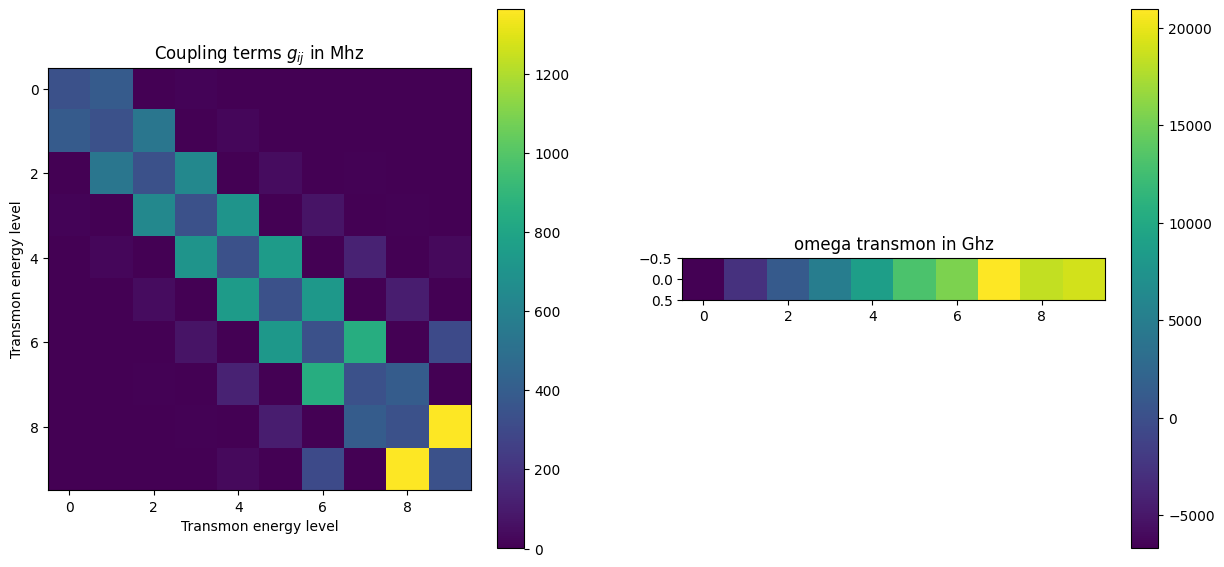

In [23]:
# Initialize transmon

# Circuit constant
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 10
ncut_t = 10

Lr = 3.5e-9
Cr = 10e-15
mcut_r = 10

# Creation of circuit object
system_2 = circuit_res_trans(Cc, Cr, Lr, mcut_r, qubit(Ej_p, [Cp], ng, ncut_p))

system_2.print_params()

g = system_2.get_g_transmon()
print(f"g : {g}")

delt = system_2.get_deltas_transmon()
print(f"delt: {delt}")

delt = delt.reshape(1,10)

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Coupling terms $g_{ij}$ in Mhz')
im1 = ax1.imshow(np.abs(g) * 1e-6 / constants.h, cmap=plt.get_cmap(thememap))
ax1.set_xlabel('Transmon energy level')
ax1.set_ylabel('Transmon energy level')
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('omega transmon in Ghz')
im2 = ax2.imshow(np.real(delt) * 1e-6 / constants.h + np.real(delt[0]), cmap=plt.get_cmap(thememap))
f.colorbar(im2)

ax1.grid(False)
ax2.grid(False)

plt.show()

Ej:    18.200000000000003 GHz
Ec:    0.2869663603653203 GHz
Cj:    270.0 fF
Ej/Ec : 63.42206792751119
w_01:    6.162432921919607 GHz
ng:    0.5
Cc:    18.0 fF
Cr:    10.0 fF
Lr:    3.5 nH
Z0:    591.6079783099616 Ohm
wr:    26.90209546303806 Ghz


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:57<00:00, 17.54it/s]


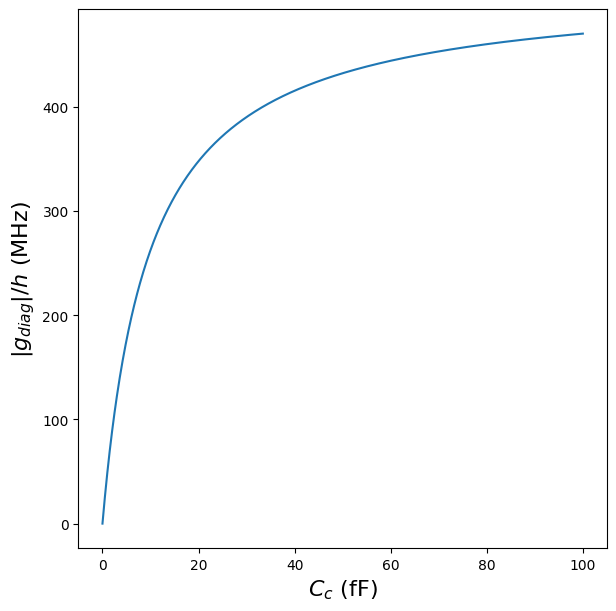

In [24]:
# Initialize transmon

# Circuit constant
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 10
ncut_t = 10

Lr = 3.5e-9
Cr = 10e-15
mcut_r = 10

# Creation of circuit object
system_3 = circuit_res_trans(Cc, Cr, Lr, mcut_r, qubit(Ej_p, [Cp], ng, ncut_p))

system_3.print_params()

Ccs = np.linspace(0, 10e-14, 1000)

fig_data_gparr = []


for Cc in tqdm(Ccs):
    system_3.Cc = Cc

    # Full Hamiltonina Approach
    g_parr = system_3.get_g_transmon(update=True)
    fig_data_gparr.append(g_parr)


pparam = dict(xlabel='$C_c$ (fF)', ylabel='$| g_{diag} | / h$ (MHz)')

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in Ccs], [np.abs(g_parr[0,0]) * 1e-6 / constants.h for g_parr in fig_data_gparr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)

    plt.show()

Ej:    18.200000000000003 GHz
Ec:    0.2869663603653203 GHz
Cj:    270.0 fF
Ej/Ec : 63.42206792751119
w_01:    6.162432921919607 GHz
ng:    0.5
Cc:    18.0 fF
Cr:    10.0 fF
Lr:    3.5 nH
Z0:    591.6079783099616 Ohm
wr:    26.90209546303806 Ghz


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


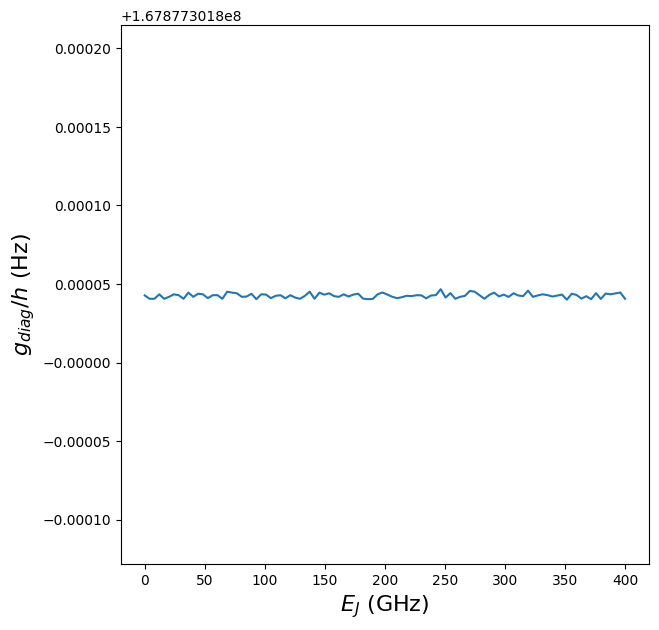

In [25]:
# Initialize transmon

# Circuit constant
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 10
ncut_t = 10

Lr = 3.5e-9
Cr = 10e-15
mcut_r = 10

# Creation of circuit object
system_4 = circuit_res_trans(Cc, Cr, Lr, mcut_r, qubit(Ej_p, [Cp], ng, ncut_p))

system_4.print_params()

Ejps = np.linspace(0, 400e9, 100)
fig_data_gparr = []

for Ejp in tqdm(Ejps):
    system_4.qubit.Ej = Ejp

    # Full Hamiltonina Approach
    g_parr = system_4.get_g_transmon(update=True)
    fig_data_gparr.append(g_parr)
    


with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    pparam = dict(xlabel='$E_{J}$ (GHz)', ylabel='$g_{diag}   / h$ (Hz)')
    ax1.plot([val * 1e-9 for val in Ejps], [np.abs(g_parr[0,0]) / h for g_parr in fig_data_gparr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)


    plt.show()

Ej:    18.200000000000003 GHz
Ec:    0.2869663603653203 GHz
Cj:    270.0 fF
Ej/Ec : 63.42206792751119
w_01:    6.162432921919607 GHz
ng:    0.5
Cc:    18.0 fF
Cr:    10.0 fF
Lr:    3.5 nH
Z0:    591.6079783099616 Ohm
wr:    26.90209546303806 Ghz


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 17.17it/s]


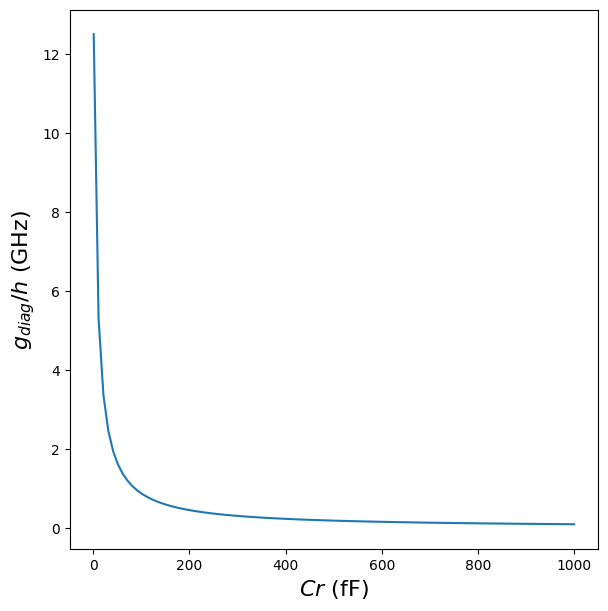

In [26]:
# Initialize transmon

# Circuit constant
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 10
ncut_t = 10

Lr = 3.5e-9
Cr = 10e-15
mcut_r = 10

# Creation of circuit object
system_6 = circuit_res_trans(Cc, Cr, Lr, mcut_r, qubit(Ej_p, [Cp], ng, ncut_p))

system_6.print_params()

Cps = np.linspace(1e-15, 10e-13, 100)
fig_pt_detuning_C_g_parr = []
fig_pt_detuning_C_g_perp = []
fig_pt_detuning_Ct = np.linspace(1e-15, 10e-13, 100)
fig_pt_detuning_Ct_g_parr = []
fig_pt_detuning_Ct_g_perp = []
fig_data_gparr = []
for Cp in tqdm(Cps):
    system_6.qubit.C = Cp

    # Full Hamiltonina Approach
    g_parr = system_6.get_g_transmon(update=True)
    fig_data_gparr.append(g_parr)

with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    pparam = dict(xlabel='$Cr$ (fF)', ylabel='$g_{diag}  / h$ (GHz)')
    ax1 = fig.add_subplot(121)
    ax1.plot([val * 1e15 for val in Cps], [np.abs(g_parr[0,0]) * 1e-9 / h for g_parr in fig_data_gparr])
    ax1.set(**pparam)
    ax1.xaxis.label.set_size(16)
    ax1.yaxis.label.set_size(16)

    plt.show()

Ej:    18.200000000000003 GHz
Ec:    0.2869663603653203 GHz
Cj:    270.0 fF
Ej/Ec : 63.42206792751119
w_01:    6.162432921919607 GHz
ng:    0.5
Cc:    18.0 fF
Cr:    10.0 fF
Lr:    3.5 nH
Z0:    591.6079783099616 Ohm
wr:    26.90209546303806 Ghz


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 17.00it/s]


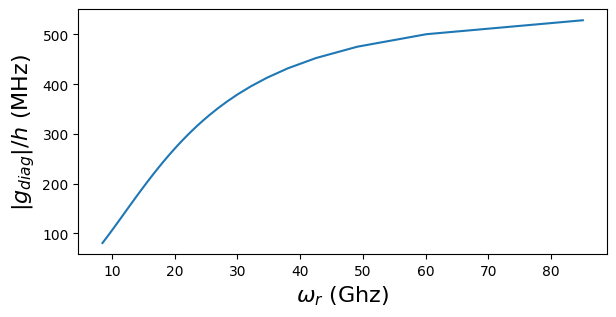

In [28]:

# Initialize transmon

# Circuit constant
Cc = 18e-15
Ej_p = 18.2e9
Ej_t = 11.8e9
Cp = 270e-15
Ct = 250e-15
ncut_p = 10
ncut_t = 10

Lr = 3.5e-9
Cr = 10e-15
mcut_r = 10

# Creation of circuit object
system_10 = circuit_res_trans(Cc, Cr, Lr, mcut_r, qubit(Ej_p, [Cp], ng, ncut_p))

system_10.print_params()

Cps = np.linspace(1e-15, 10e-13, 100)

fig_data = []

Ccr = np.linspace(10e-14, 10e-16, 100)

for Cc in tqdm(Ccr):
    system_10.res_Cr = Cc

    # Full Hamiltonina Approach
    J_matrix = system_10.get_g_transmon(update=True)
    fig_data.append(J_matrix)


with plt.style.context([]):
    fig = plt.figure(figsize=(15,7))
    pparam = dict(xlabel='$\omega_{r}$ (Ghz)', ylabel='$| g_{diag} | / h$ (MHz)')

    ax4 = fig.add_subplot(224)
    ax4.plot([(constants.hbar / np.sqrt(system_10.res_Lr * val)) / constants.h * 1e-9 for val in Ccr], [2 * np.mean(np.abs(J_matrix)) * 1e-6 / h for J_matrix in fig_data])
    ax4.set(**pparam)
    ax4.xaxis.label.set_size(16)
    ax4.yaxis.label.set_size(16)
    plt.show()